In [166]:
! pip3 install torch
! pip install scipy


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\harsh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\harsh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [167]:
import torch
print(torch.__version__)
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import wandb

2.1.0+cpu


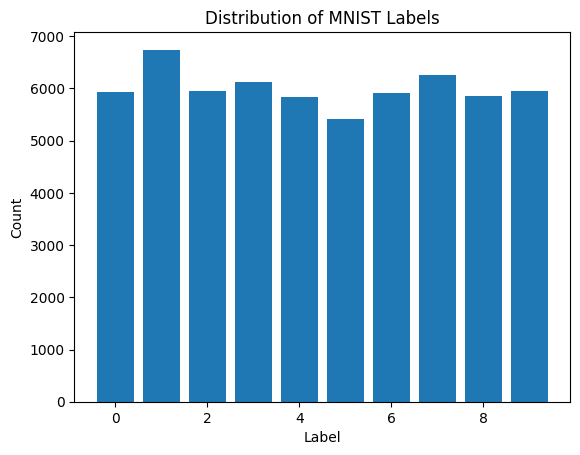

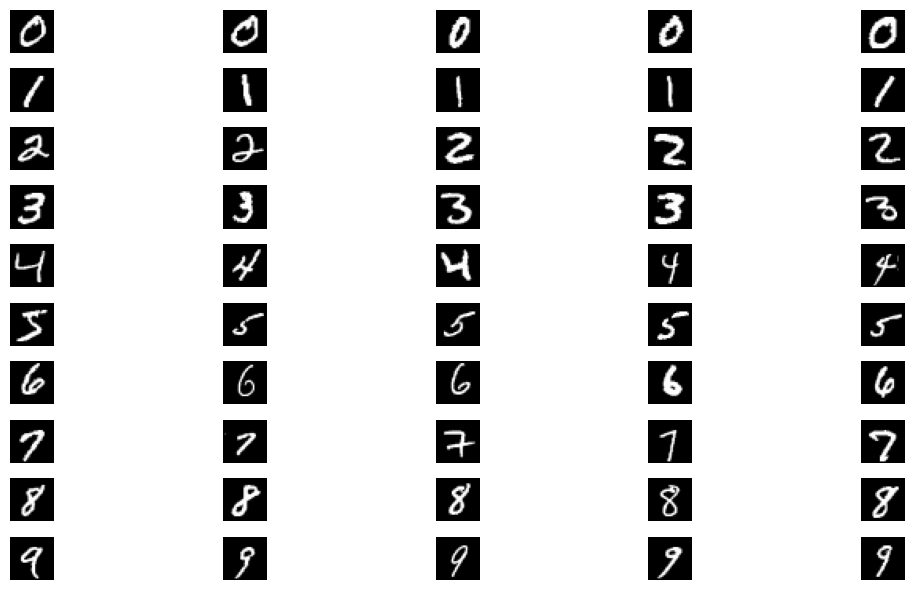

In [168]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./', train=True, download=True, transform=transform)

label_counts = np.zeros(10)
for _, label in mnist_train:
    label_counts[label] += 1

plt.bar(range(0, 10), label_counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of MNIST Labels')
plt.show()

samples_per_class = {}

for data, label in mnist_train:
    if label not in samples_per_class.keys():
        samples_per_class[label] = [data]
    else:
        if len(samples_per_class[label]) < 5:
            samples_per_class[label].append(data)

plt.figure(figsize=(12, 6))
for label, images in samples_per_class.items():
    for i, image in enumerate(images):
        plt.subplot(10, 5, label * 5 + i + 1)
        plt.imshow(image.squeeze().numpy(), cmap='gray')
        plt.axis('off')
plt.tight_layout()
plt.show()


In [169]:
from torch.utils.data import DataLoader

train_size = int(0.8 * len(mnist_train))
val_size = int(0.1 * len(mnist_train))
test_size = len(mnist_train) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(mnist_train, [train_size, val_size, test_size])

batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)


In [170]:
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self, dropout_rate = 0.25):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [171]:
import torch.optim as optim

model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    correct = 0
    total = 0
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Epoch [{epoch + 1}/{num_epochs}] | Loss: {loss.item():.4f} | Validation Accuracy: {accuracy:.2f}%')


Epoch [1/10] | Loss: 0.1365 | Validation Accuracy: 96.68%
Epoch [2/10] | Loss: 0.0895 | Validation Accuracy: 97.85%
Epoch [3/10] | Loss: 0.1370 | Validation Accuracy: 97.88%
Epoch [4/10] | Loss: 0.0182 | Validation Accuracy: 98.20%
Epoch [5/10] | Loss: 0.0313 | Validation Accuracy: 98.35%
Epoch [6/10] | Loss: 0.1340 | Validation Accuracy: 98.52%
Epoch [7/10] | Loss: 0.0262 | Validation Accuracy: 98.77%
Epoch [8/10] | Loss: 0.0748 | Validation Accuracy: 98.73%
Epoch [9/10] | Loss: 0.0865 | Validation Accuracy: 98.68%
Epoch [10/10] | Loss: 0.1469 | Validation Accuracy: 98.75%


In [172]:
def visualize_feature_maps(model, image, layer_name):
    model.eval()
    feature_maps = None
    def hook(module, input, output):
        nonlocal feature_maps
        feature_maps = output
    target_layer = None
    for name, module in model.named_modules():
        if name == layer_name:
            target_layer = module
            break
    if target_layer is None:
        print(f"Layer '{layer_name}' not found in the model.")
        return
    hook_handle = target_layer.register_forward_hook(hook)
    with torch.no_grad():
        image = image.unsqueeze(0)
        model(image)
    hook_handle.remove()
    feature_maps = feature_maps.squeeze().cpu().numpy()
    num_feature_maps = feature_maps.shape[0]
    if num_feature_maps <= 4:
        rows, cols = 1, num_feature_maps
    else:
        cols = 4
        rows = int(np.ceil(num_feature_maps / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    for i in range(num_feature_maps):
        if rows > 1:
            ax = axes[i // cols, i % cols]
        else:
            ax = axes[i]
        ax.imshow(feature_maps[i], cmap='viridis')
        ax.axis('off')
        ax.set_title(f'Feature Map {i + 1}')
    plt.figure(figsize=(5, 5))
    plt.imshow(image.squeeze().cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.title('Input Image')
    plt.tight_layout()
    plt.show()

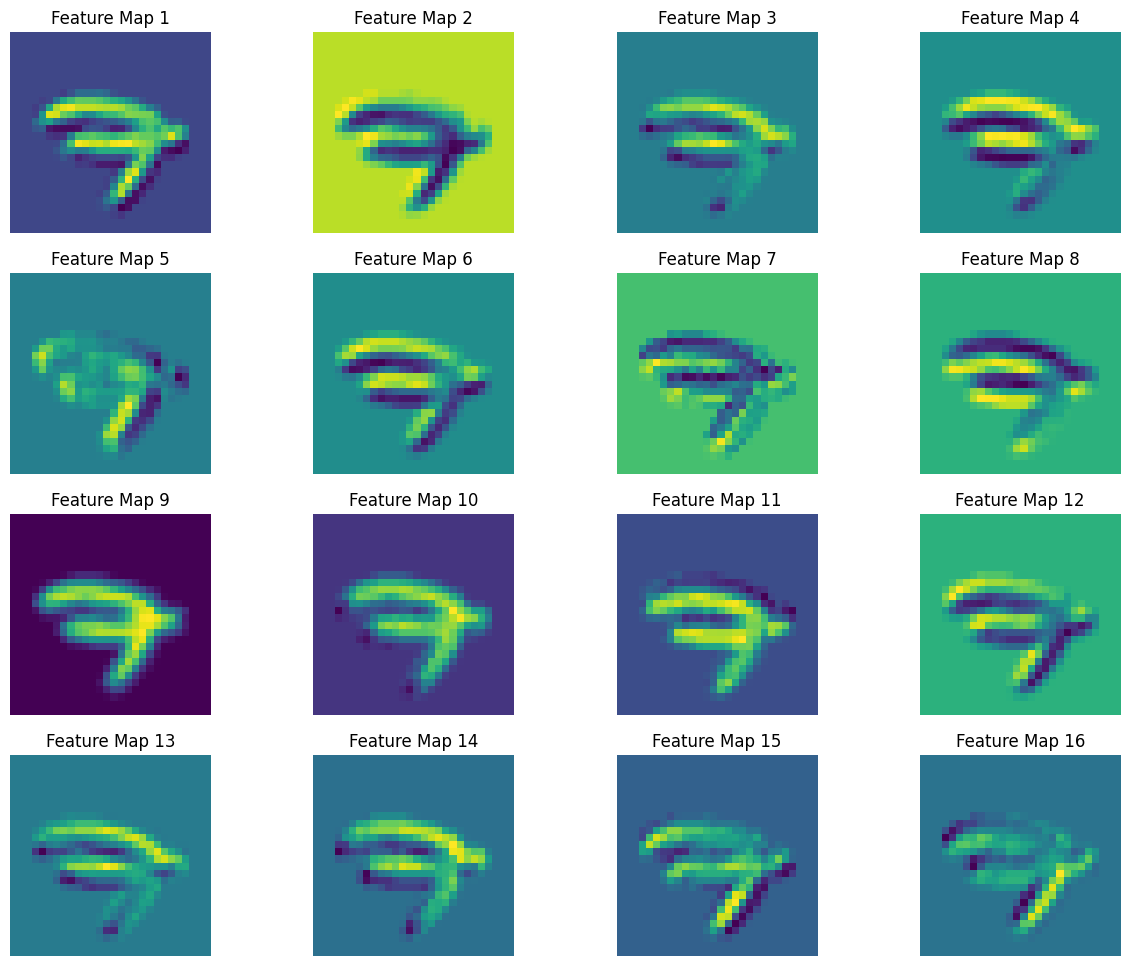

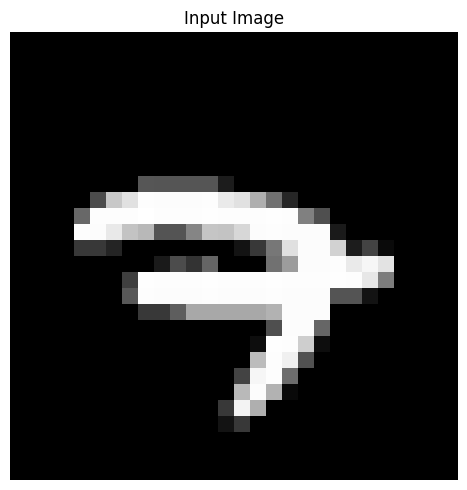

In [173]:
image, label = test_set[0]
layer_name = 'conv1'
visualize_feature_maps(model, image, layer_name)

In [175]:
wandb.init(project="smai_assignment_3_4", entity="harshitaggarwal4")

config = wandb.config
config.learning_rate = [0.001, 0.01, 0.0001]
config.batch_size = [32, 64, 128]
config.num_epochs = 10
config.dropout_rate = [0.0, 0.25, 0.5]

best_accuracy = 0.0
best_model_state = None

transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./', train=True, download=True, transform=transform)

train_size = int(0.8 * len(mnist_train))
val_size = int(0.1 * len(mnist_train))
test_size = len(mnist_train) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(mnist_train, [train_size, val_size, test_size])

def create_data_loader(dataset, batch_size):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

for lr in config.learning_rate:
    for batch_size in config.batch_size:
        for dropout_rate in config.dropout_rate:
            model = CNNModel(dropout_rate = dropout_rate)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)

            train_loader = create_data_loader(train_set, batch_size)
            val_loader = create_data_loader(val_set, batch_size)

            for epoch in range(config.num_epochs):
                model.train()
                for images, labels in train_loader:
                    optimizer.zero_grad()
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                model.eval()
                correct = 0
                total = 0
                for images, labels in val_loader:
                    outputs = model(images)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                accuracy = 100 * correct / total

                wandb.log({
                    "Learning Rate": lr,
                    "Batch Size": batch_size,
                    "Dropout Rate": dropout_rate,
                    "Epoch": epoch + 1,
                    "Train Loss": loss.item(),
                    "Validation Accuracy": accuracy
                })

                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_model_state = model.state_dict()

torch.save(best_model_state, 'model_best.pth')

wandb.finish()

Batch Size,▁▁▁
Dropout Rate,▁▁▁
Epoch,▁▅█
Learning Rate,▁▁▁
Train Loss,█▁▃
Validation Accuracy,▁▅█
Batch Size,32
Dropout Rate,0.0
Epoch,3
Learning Rate,0.001
Train Loss,0.07525


Batch Size,▁▁▁▁▁▃▃▃▃████▁▁▁▁▁▃▃▃▃█████▁▁▁▁▃▃▃▃▃████
Dropout Rate,▁▁▅██▁▅▅█▁▁▅█▁▁▅██▁▅▅█▁▁▅██▁▅▅█▁▁▅██▁▅▅█
Epoch,▃▆▅▃▆▅▃▆▅▃▆▅▃▁▅▃▁▅▃▁▅▃▁▅▃▁█▃▁█▃▁█▃▁█▃▁█▆
Learning Rate,▂▂▂▂▂▂▂▂▂▂▂▂▂██████████████▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,▁▁▃▄▂▁▁▁▁▁▂▄▂▁▃▃▅▄▁▁▃▄▂▂▄▄▃▄▃▃▅▅▂▅█▄▅█▄▅
Validation Accuracy,████████████▇▆▇▇▇▇▇▇▇█▇█▇▇▇▆▄▇▆▃▇▄▂▇▃▁▆▅
Batch Size,128
Dropout Rate,0.5
Epoch,10
Learning Rate,0.0001
Train Loss,0.16834


In [176]:
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./', train=True, download=True, transform=transform)

train_size = int(0.8 * len(mnist_train))
val_size = int(0.1 * len(mnist_train))
test_size = len(mnist_train) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(mnist_train, [train_size, val_size, test_size])

def create_data_loader(dataset, batch_size):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

batch_size = 32
learning_rate = 0.001
dropout_rate = 0.25
num_epochs = 10

best_model = CNNModel(dropout_rate = dropout_rate)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=learning_rate)

train_loader = create_data_loader(train_set, batch_size)
val_loader = create_data_loader(val_set, batch_size)

for epoch in range(num_epochs):
    best_model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = best_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    best_model.eval()
    correct = 0
    total = 0
    for images, labels in val_loader:
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total

In [177]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

best_model.eval()
test_correct = 0
test_total = 0
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = best_model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

class_accuracy = []
for class_label in range(10):
    class_correct = sum([(p == class_label) and (t == class_label) for p, t in zip(predictions, true_labels)])
    class_total = true_labels.count(class_label)
    class_accuracy.append(class_correct / class_total)
    print(f"Accuracy for class {class_label}: {class_accuracy[-1] * 100:.2f}%")

print("Classification Report:\n", classification_report(true_labels, predictions))


Test Accuracy: 99.35%
Accuracy for class 0: 99.65%
Accuracy for class 1: 98.74%
Accuracy for class 2: 99.47%
Accuracy for class 3: 99.53%
Accuracy for class 4: 99.00%
Accuracy for class 5: 99.27%
Accuracy for class 6: 99.65%
Accuracy for class 7: 99.17%
Accuracy for class 8: 99.35%
Accuracy for class 9: 99.82%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       573
           1       1.00      0.99      0.99       714
           2       0.99      0.99      0.99       569
           3       1.00      1.00      1.00       639
           4       0.99      0.99      0.99       602
           5       1.00      0.99      1.00       545
           6       0.99      1.00      0.99       569
           7       0.99      0.99      0.99       603
           8       0.99      0.99      0.99       618
           9       0.99      1.00      0.99       568

    accuracy                           0.99      6000
   macro avg  

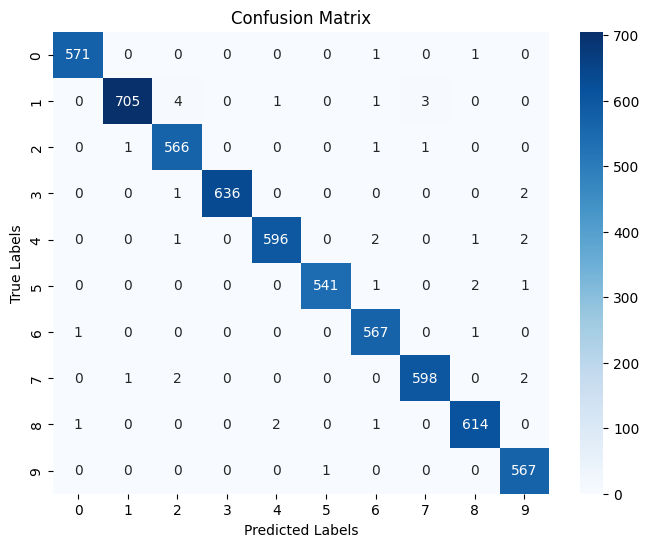

In [178]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [179]:
import scipy.io
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

mat_file = scipy.io.loadmat('mnist-with-awgn.mat')

x_train = mat_file['train_x']  
y_train = mat_file['train_y']  
x_test = mat_file['test_x']    
y_test = mat_file['test_y']  

x_trainn = []
for i in range(len(x_train)):
    x_trainn.append([x_train[i].reshape(28, 28)])
x_train = np.array(x_trainn)

x_testt = []
for i in range(len(x_test)):
    x_testt.append([x_test[i].reshape(28, 28)])
x_test = np.array(x_testt)

test_size = 0.5
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=test_size, random_state=42)

x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)
x_val = torch.from_numpy(x_val)
y_val = torch.from_numpy(y_val)

x_train = x_train.to(torch.float32)
y_train = y_train.to(torch.float32)
x_test = x_test.to(torch.float32)
y_test = y_test.to(torch.float32)
x_val = x_val.to(torch.float32)
y_val = y_val.to(torch.float32)

train_set = TensorDataset(x_train, y_train)
test_set = TensorDataset(x_test, y_test)
val_set = TensorDataset(x_val, y_val)

In [180]:
def create_data_loader(dataset, batch_size):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

batch_size = 32
learning_rate = 0.001
dropout_rate = 0.25
num_epochs = 10

best_model = CNNModel(dropout_rate = dropout_rate)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=learning_rate)

train_loader = create_data_loader(train_set, batch_size)
val_loader = create_data_loader(val_set, batch_size)


for epoch in range(num_epochs):
    best_model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = best_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    best_model.eval()
    correct = 0
    total = 0
    for images, labels in val_loader:
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        _, label = torch.max(labels, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
    accuracy = 100 * correct / total
    print(accuracy)

94.26
96.3
96.82
97.16
96.8
97.0
97.26
97.36
96.96
97.9


In [181]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

best_model.eval()
test_correct = 0
test_total = 0
predictions = []
true_labels = []

test_loader = create_data_loader(test_set, batch_size)

with torch.no_grad():
    for images, labels in test_loader:
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        _, label = torch.max(labels, 1)
        test_total += label.size(0)
        test_correct += (predicted == label).sum().item()
        predictions.extend(predicted.tolist())
        true_labels.extend(label.tolist())

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

class_accuracy = []
for class_label in range(10):
    class_correct = sum([(p == class_label) and (t == class_label) for p, t in zip(predictions, true_labels)])
    class_total = true_labels.count(class_label)
    class_accuracy.append(class_correct / class_total)
    print(f"Accuracy for class {class_label}: {class_accuracy[-1] * 100:.2f}%")

print("Classification Report:\n", classification_report(true_labels, predictions))


Test Accuracy: 97.24%
Accuracy for class 0: 98.38%
Accuracy for class 1: 98.35%
Accuracy for class 2: 97.88%
Accuracy for class 3: 98.60%
Accuracy for class 4: 97.37%
Accuracy for class 5: 98.47%
Accuracy for class 6: 97.60%
Accuracy for class 7: 95.31%
Accuracy for class 8: 95.11%
Accuracy for class 9: 95.30%
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       494
           1       0.99      0.98      0.99       545
           2       0.96      0.98      0.97       518
           3       0.98      0.99      0.98       499
           4       0.97      0.97      0.97       495
           5       0.96      0.98      0.97       457
           6       0.99      0.98      0.98       500
           7       0.96      0.95      0.96       512
           8       0.98      0.95      0.96       491
           9       0.95      0.95      0.95       489

    accuracy                           0.97      5000
   macro avg  

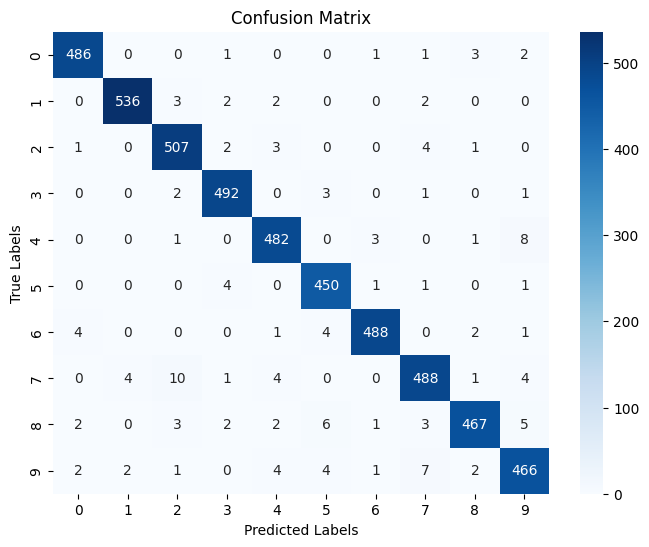

In [182]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [183]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./', train=True, transform=transform, download=True)

In [184]:
def add_gaussian_noise(tensor, mean=0, std_dev=0.4):
    noise = torch.randn_like(tensor) * std_dev + mean
    noisy_tensor = torch.clamp(tensor + noise, 0, 1)
    return noisy_tensor

noisy_train_dataset = []
for image, label in train_dataset:
    noisy_image = add_gaussian_noise(image)
    noisy_train_dataset.append((noisy_image, label))

In [185]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        return self.encoder(x)

In [186]:
def create_data_loader(dataset, batch_size):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

batch_size = 64
learning_rate = 0.001
num_epochs = 10

model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loader = create_data_loader(train_dataset, batch_size)

for epoch in range(num_epochs):
    for data in train_loader:
        inputs, _ = data
        noisy_inputs = add_gaussian_noise(inputs)
        optimizer.zero_grad()
        outputs = model(noisy_inputs.view(-1, 28 * 28))
        loss = criterion(outputs, inputs.view(-1, 28 * 28))
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.0275
Epoch [2/10], Loss: 0.0239
Epoch [3/10], Loss: 0.0201
Epoch [4/10], Loss: 0.0185
Epoch [5/10], Loss: 0.0171
Epoch [6/10], Loss: 0.0150
Epoch [7/10], Loss: 0.0157
Epoch [8/10], Loss: 0.0153
Epoch [9/10], Loss: 0.0154
Epoch [10/10], Loss: 0.0157


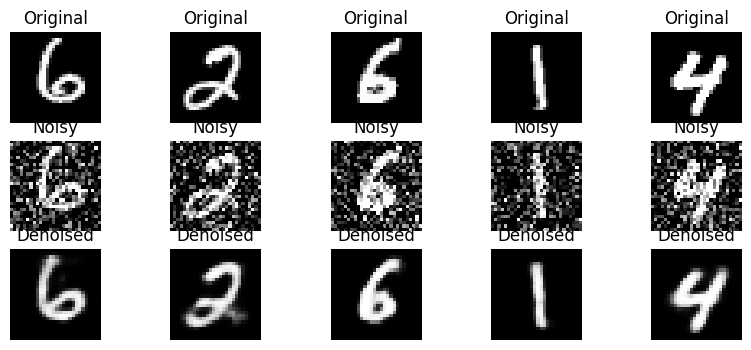

In [187]:
n = 5
plt.figure(figsize=(10, 4))
model.eval()
with torch.no_grad():
    for i, data in enumerate(train_loader, 0):
        inputs, _ = data
        noisy_inputs = add_gaussian_noise(inputs)
        outputs = model(noisy_inputs.view(-1, 28 * 28)).reshape(-1, 28, 28)

        if i < n:
            ax = plt.subplot(3, n, i + 1)
            plt.imshow(inputs[0][0], cmap='gray')
            plt.title('Original')
            plt.axis('off')

            ax = plt.subplot(3, n, i + n + 1)
            plt.imshow(noisy_inputs[0][0], cmap='gray')
            plt.title('Noisy')
            plt.axis('off')

            ax = plt.subplot(3, n, i + 2 * n + 1)
            plt.imshow(outputs[0].view(28, 28), cmap='gray')
            plt.title('Denoised')
            plt.axis('off')

            if i == n - 1:
                break

plt.show()

In [188]:
class CustomDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        sample = {
            'input': self.inputs[idx],
            'label': self.labels[idx]
        }
        return sample

In [189]:
train_loader = create_data_loader(noisy_train_dataset, len(noisy_train_dataset))

model.eval()
for images, labels in train_loader:
    outputs = model.encode(images.view(-1, 28 * 28))
    denoised_dataset_train = outputs.detach()
    denoised_dataset_train = TensorDataset(denoised_dataset_train, labels)

In [190]:
train_size = int(0.8 * len(denoised_dataset_train))
val_size = int(0.1 * len(denoised_dataset_train))
test_size = len(denoised_dataset_train) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(denoised_dataset_train, [train_size, val_size, test_size])

In [191]:
import torch.nn as nn

class linear_model(nn.Module):
    def __init__(self, dropout_rate = 0.25):
        super(linear_model, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.linear(x)
        return x

In [192]:
def create_data_loader(dataset, batch_size):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

batch_size = 32
learning_rate = 0.001
num_epochs = 10

best_model = linear_model(dropout_rate = dropout_rate)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=learning_rate)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

for epoch in range(num_epochs):
    best_model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = best_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    best_model.eval()
    correct = 0
    total = 0
    for images, labels in val_loader:
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        label = labels
        total += label.size(0)
        correct += (predicted == label).sum().item()
    accuracy = 100 * correct / total
    print(accuracy)

86.0
87.3
88.5
89.53333333333333
90.83333333333333
91.63333333333334
92.16666666666667
92.38333333333334
92.78333333333333
92.21666666666667
